# Baseline **LSTM** Frame Predictor

A companion to the Transformer notebook — shares the same dataset loading,
section layout, and training loop so you can compare apples‑to‑apples.

<small>*(Sections are numbered & boxed exactly like the Transformer notebook.)*</small>

In [1]:
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os

from custom_visualizer import (
    extract_subset_from_dataloader,
    covert_sequences_to_df,
    extract_full_sequence,
    plot_trajectories)

2025-05-01 18:26:11.521086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 18:26:11.530966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746120371.541801  118572 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746120371.544993  118572 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746120371.553236  118572 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(f"✅ Using GPU: {gpus[0].name}")
        # Enable soft memory growth for the CPU
        tf.config.set_soft_device_placement(True)
        # Set mixed precision policy
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
    except RuntimeError as e:
        print("Failed to set GPU memory growth:", e)
else:
    print("No GPU found. Using CPU.")

✅ Using GPU: /physical_device:GPU:0


In [3]:
# ╔════════════════════╗
# ║ 1. Load  Dataset  ║
# ╚════════════════════╝
DATA_PATH = "../processed_data/transformer_dataset_predlen40"
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

full_ds = tf.data.Dataset.load(DATA_PATH)

train_ds = (
    full_ds
      .filter(lambda m,x,y: m[2]==0)
      .map(lambda m,x,y: (x,y), num_parallel_calls=AUTOTUNE)
      .shuffle(2048)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
      .repeat()
)
val_ds = (
    full_ds
        .filter(lambda m, x, y: m[2] == 1)
        .map(lambda m, x, y: (x, y), num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
)

# Peek at one batch
for x_batch, y_true_flat in train_ds.take(1):
    print("x_batch shape:", x_batch.shape)        
    print("y_true_flat shape:", y_true_flat.shape) 

for x_batch, y_true_flat in val_ds.take(1):
    print("x_batch shape:", x_batch.shape)       
    print("y_true_flat shape:", y_true_flat.shape)

I0000 00:00:1746120374.139946  118572 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


x_batch shape: (64, 100, 46)
y_true_flat shape: (64, 40, 46)


2025-05-01 18:26:16.366151: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


x_batch shape: (64, 100, 46)
y_true_flat shape: (64, 40, 46)


2025-05-01 18:26:23.156695: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Hyper-parameters
LSTM_UNITS = 300
MAX_LEN = 100
NUM_PLAYERS = 23
NUM_FEATS = 2 * NUM_PLAYERS
PRED_LEN = 40

# Loss: mean Euclidean distance per player per frame
def euclidean_distance_loss(y_true, y_pred, pred_len=PRED_LEN, num_players=NUM_PLAYERS):
    # reshape to (batch, pred_len, players, coords)
    diff = K.reshape(y_pred - y_true, (-1, pred_len, num_players, 2))
    # squared diffs
    sq_diff = K.square(diff)
    # sum over coords -> (batch, pred_len, players)
    sum_sq_coords = K.sum(sq_diff, axis=-1)
    # euclidean distance per player per frame
    dist_per_player = K.sqrt(sum_sq_coords + K.epsilon())
    # mean over players -> (batch, pred_len)
    mean_per_frame = K.mean(dist_per_player, axis=-1)
    # mean over frames -> (batch,)
    mean_per_sample = K.mean(mean_per_frame, axis=-1)
    # mean over batch
    return K.mean(mean_per_sample)


def build_lstm_seq2seq_attention(max_len=MAX_LEN,
                                 num_feats=NUM_FEATS,
                                 lstm_units=LSTM_UNITS,
                                 pred_len=PRED_LEN):
    # Encoder
    encoder_inputs = layers.Input((max_len, num_feats), name="encoder_inputs")
    encoder_outputs, state_h, state_c = layers.LSTM(
        lstm_units,
        return_sequences=True,
        return_state=True,
        name="lstm_encoder"
    )(encoder_inputs)

    # zero‐decoder inputs
    zero_inputs = layers.Lambda(
        lambda x: tf.zeros((tf.shape(x)[0], pred_len, num_feats)),
        output_shape=(pred_len, num_feats),
        name="zero_decoder_inputs"
    )(encoder_inputs)

    # single Embedding layer, but do lookup+tile in one Lambda
    pos_embedding = layers.Embedding(pred_len, num_feats, name="pos_embedding")
    decoder_pos = layers.Lambda(
        lambda x: tf.tile(
            tf.expand_dims(pos_embedding(tf.range(pred_len)), 0),
            [tf.shape(x)[0], 1, 1]
        ),
        output_shape=(pred_len, num_feats),
        name="pos_emb_batched"
    )(encoder_inputs)

    # now broadcast nicely: shape(zero_inputs) = (batch, pred_len, num_feats)
    #                     shape(decoder_pos) = (batch, pred_len, num_feats)
    decoder_inputs = layers.Add(name="add_positional_inputs")([zero_inputs, decoder_pos])

    # Autoregressive decoder
    decoder_cell = layers.LSTMCell(lstm_units, name="lstm_decoder_cell")
    decoder_rnn = layers.RNN(decoder_cell, return_sequences=True, name="lstm_decoder")
    decoder_outputs = decoder_rnn(decoder_inputs, initial_state=[state_h, state_c])

    # Attention & final projection
    context = layers.Attention(name="attention")([decoder_outputs, encoder_outputs])
    concat = layers.Concatenate(name="concat_context")([decoder_outputs, context])
    x = layers.TimeDistributed(layers.Dense(lstm_units, activation="relu"), name="dense_relu_time")(concat)
    decoder_pred = layers.TimeDistributed(layers.Dense(num_feats), name="pred_xy")(x)

    return keras.Model(encoder_inputs, decoder_pred, name="LSTM_Seq2Seq_Attn")

# Instantiate and inspect
model = build_lstm_seq2seq_attention()
model.summary()

Model: "LSTM_Seq2Seq_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 100, 46)   │          0 │ encoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 100, 46)   │          0 │ encoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_decoder_inputs │ (None, 40, 46)    │          0 │ cast_1[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_emb_batched     │ (None, 40, 46)    │          0 │ cast_2[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 100, 46)   │          0 │ encoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_positional_inp… │ (None, 40, 46)    │          0 │ zero_decoder_inp… │
│ (Add)               │                   │            │ pos_emb_batched[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_encoder (LSTM) │ [(None, 100,      │    416,400 │ cast[0][0]        │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_decoder (RNN)  │ (None, 40, 300)   │    416,400 │ add_positional_i… │
│                     │                   │            │ lstm_encoder[0][… │
│                     │                   │            │ lstm_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 40, 300)   │          0 │ lstm_decoder[0][… │
│ (Attention)         │                   │            │ lstm_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_context      │ (None, 40, 600)   │          0 │ lstm_decoder[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_relu_time     │ (None, 40, 300)   │    180,300 │ concat_context[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_xy             │ (None, 40, 46)    │     13,846 │ dense_relu_time[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,026,946 (3.92 MB)

 Trainable params: 1,026,946 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ╔════════════════════════════════════════╗
# ║        Set up callbacks                ║
# ╚════════════════════════════════════════╝
NUM_PATIENCE = 5
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=NUM_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    filepath="saved_models/lstm_att40f_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [6]:
# ╔══════════════════════╗
# ║       Compile        ║
# ╚══════════════════════╝
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=euclidean_distance_loss,
    metrics=["mae"]
)

In [7]:
%%time
# ╔══════════════════════╗
# ║       Train          ║
# ╚══════════════════════╝
EPOCHS = 100
STEPS_PER_EPOCH_TRAIN = 1000
STEPS_PER_EPOCH_VAL = 200

# Train the model
history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
    validation_steps=STEPS_PER_EPOCH_VAL,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint_cb],
    verbose=1
    )

Epoch 1/100


2025-05-01 18:26:26.395949: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1746120387.565121  118677 cuda_dnn.cc:529] Loaded cuDNN version 90300


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1162 - mae: 0.0733
Epoch 1: val_loss improved from inf to 0.04956, saving model to saved_models/lstm_att40f_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 203s 198ms/step - loss: 0.1161 - mae: 0.0733 - val_loss: 0.0496 - val_mae: 0.0309
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0404 - mae: 0.0252
Epoch 2: val_loss improved from 0.04956 to 0.03696, saving model to saved_models/lstm_att40f_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - loss: 0.0404 - mae: 0.0252 - val_loss: 0.0370 - val_mae: 0.0231
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0323 - mae: 0.0202
Epoch 3: val_loss improved from 0.03696 to 0.03103, saving model to saved_models/lstm_att40f_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 192s 192ms/step - loss: 0.0323 - mae: 0.0202 - val_loss: 0.0310 - val_mae: 0.0193
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0279 - mae: 0.0174
Epoch 4: val_loss imp

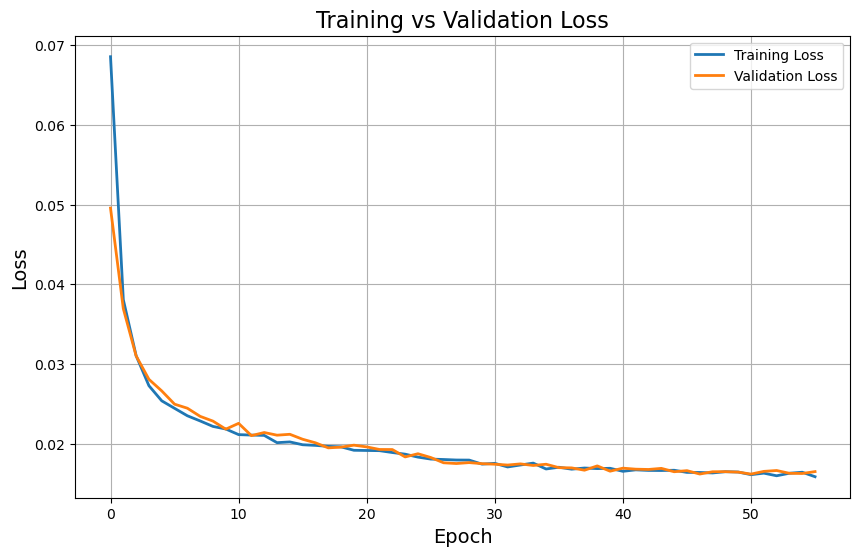

In [8]:
# ╔════════════════╗
# ║ Curves Plot    ║
# ╚════════════════╝
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training vs Validation Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()